### PACKAGES, OPTIONS, CONSTANTS

In [1]:
import os
from os import listdir
from os.path import isfile, join

import requests
from time import sleep
import credentials # script python con las credenciales almacenadas en un diccionario
import locale

import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

### FUNCTIONS

In [2]:
def etl_hospitalizaciones():
    """
    Generación de df histórico de ingresos, altas y ocupación de hospitales a partir de extracción de CMBD.
    """
    
    # Hospitalizaciones
    filename = 'CMBD_6_20181217-135856.xlsx'
    path = os.path.join('..', 'data', 'external', 'hospitalizaciones', filename)
    raw_df = pd.read_excel(path)
    
    date_cols = ['Fecha de ingreso', 'Fecha de alta']
    keep_cols = ['Sexo', 'Edad', 'Diagnóstico Principal', 'Estancia', 'Coste']
    
    for col in date_cols:
        """
        Dates are codified as integer in DDMMYYYY format, so there's no padding zero if day < 10, i.e:
        28042013 -> 2013-04-28
        7022013 -> 2013-02-07
        """
        raw_df[col + ' new'] = pd.to_datetime(raw_df[col].map(lambda col: str(col).zfill(8)), format='%d%m%Y', errors = 'coerce')
    
    interim_df = raw_df[keep_cols].copy()
    
    for col in date_cols:
        interim_df[col] = raw_df[col + ' new'].copy()
        
     # Ingresos y altas by date
    ingresos_diarios_df = interim_df.groupby(['Fecha de ingreso']).size().reset_index(name = 'Ingresos')
    ingresos_diarios_df.set_index('Fecha de ingreso', inplace = True)
    ingresos_diarios_df.index.names = ['Fecha']
    
    altas_diarias_df = interim_df.groupby(['Fecha de alta']).size().reset_index(name = 'Altas')
    altas_diarias_df.set_index('Fecha de alta', inplace = True)
    altas_diarias_df.index.names = ['Fecha']
    
    # Join by date, cumsum
    hospitalizaciones_df = altas_diarias_df.join(ingresos_diarios_df, how= 'outer')
    hospitalizaciones_df['Ingresos acumulados'] = hospitalizaciones_df['Ingresos'].cumsum()
    hospitalizaciones_df['Altas acumuladas'] = hospitalizaciones_df['Altas'].cumsum()
    hospitalizaciones_df['Ocupacion'] = hospitalizaciones_df['Ingresos acumulados'] - hospitalizaciones_df['Altas acumuladas']
    
    # Export to csv
    hospitalizaciones_df.to_csv(os.path.join('..', 'data', 'processed', 'hospitalizaciones'))
    
    return hospitalizaciones_df


def etl_calidad_aire():
    """
    Generación de df con datos de calidad del aire a partir de histórico en conjunto de ficheros csv.
    """
    
    path = os.path.join('..', 'data', 'external', 'calidad_aire')
    
    # Cargar tabla magnitudes, unidades y técnicas de medida.
    mag_uni_tec_df = pd.read_csv(os.path.join(path,'magnitudes_unidades_tecnicas_medida.csv'))
    
    # Listar ficheros de datos de calidad del aire.
    list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
    list_of_csv_files = [file for file in list_of_files if file.endswith('csv') and file.startswith('datos')]
    
    # Concatenar ficheros de calidad del aire en df.
    raw_df = pd.concat([pd.read_csv(os.path.join(path, file), delimiter = ';') for file in list_of_csv_files])

    #raw_df = pd.read_csv(csv_path, delimiter = ';')
    raw_df = raw_df.merge(mag_uni_tec_df[['MAGNITUD ID', 'MAGNITUD ABREV']], 
                          left_on = 'MAGNITUD', 
                          right_on = 'MAGNITUD ID', 
                          how= 'left') # Pegar descripción de magnitud.
    
    # Trasponer wide to long => añomes to día
    id_cols = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD ABREV', 'PUNTO_MUESTREO', 'ANO', 'MES']
    value_cols = ['D' + str(n).zfill(2) for n in range(1,32,1)]
    
    interim_df = pd.melt(raw_df, id_cols, value_cols)
    interim_df['DIA'] = interim_df['variable'].map(lambda var: var[1:])
    interim_df['FECHA'] = pd.to_datetime(interim_df['ANO'].astype(str) 
                                          + interim_df['MES'].astype(str).str.zfill(2)
                                          + interim_df['DIA'], 
                                         format='%Y%m%d', errors = 'coerce')
    
    key = ['FECHA', 'MAGNITUD ABREV']
    calidad_aire_t_df = interim_df[key + ['value']].groupby(key).mean()
    
    # Trasponer long to wide => fecha, medida 1, medida 2, ..., medida n
    calidad_aire_df = calidad_aire_t_df.pivot_table(index= 'FECHA', 
                                                    columns= 'MAGNITUD ABREV', 
                                                    values= 'value')
    
    return calidad_aire_df


def etl_tabaquismo():
    """
    Generación de df con datos históricos de consumo de tabaco, a partir de agregación de datos de INCLASNS.
    """
    
    # Cargar csv
    path = os.path.join('..', 'data', 'external', 'tabaquismo')
    filename = "inclasns_tabaquismo.csv"
    raw_df = pd.read_csv(os.path.join(path, filename))
    
    # Generar fecha a partir de año
    raw_df['FECHA'] = pd.to_datetime(raw_df['ANO'].astype(str) + '01' + '01', 
                                     format='%Y%m%d', errors = 'coerce')
    
    # Pivotar wide to long => generar [CCAA, value]
    drop_cols = ['ANO']
    id_cols = ['FECHA', 'SEXO']
    value_cols = list(set(raw_df.columns.values).difference(set(drop_cols).union(set(id_cols)))) # Las columnas CCAA son todas las del df menos las id de pivot y las que dropeamos
    interim_df = pd.melt(raw_df, id_cols, value_cols)
    interim_df.rename(columns = {"variable": "CCAA", "value": "PCT_tabaquismo"}, # Renombrar por legibilidad de la siguiente trasposición
                      inplace = True)
    
    # Trasponer long to wide => generar [PCT_tabaquismo_H, PCT_Tabaquismo_M, PCT_Tabaquismo
    tabaquismo_df = interim_df.pivot_table(index= ['FECHA','CCAA'], 
                                           columns= 'SEXO', 
                                           values= 'PCT_tabaquismo')
    
    rename_cols = {col: 'PCT_tabaquismo_' + col.lower() for col in tabaquismo_df.columns.values}
    tabaquismo_df.rename(columns = rename_cols, 
                         inplace = True)
    
    # Dividir entre 100 para representar porcentaje.
    for col in tabaquismo_df.columns.values:
        tabaquismo_df[col] = tabaquismo_df[col] / 100
        
    tabaquismo_df.reset_index(inplace = True)
    tabaquismo_df.rename_axis(None, axis=1, inplace = True)
    tabaquismo_df.set_index(keys = 'FECHA', inplace = True)
    
    return tabaquismo_df


def etl_polen():
    """
    Generación de df con concentraciones de distintos tipos de polen a nivel mensual, a partir de calendario polínico de España.
    """
    
    path = os.path.join('..', 'data', 'external', 'polen')
    filename = "calendario_polinico_espana.csv"
    polen_df = pd.read_csv(os.path.join(path, filename))
    polen_df.set_index('Mes', inplace = True)
    
    return polen_df


def etl_climatologia():
    """
    Generación de df con información de datos climáticos.
    """
    
    # Parámetros de la request a la API
    anyo_ini = 2000
    anyo_fin = 2021
    endpoint = "https://opendata.aemet.es/opendata/api/valores/climatologicos/diarios/datos/"
    estacion = 3195
    querystring = {'api_key': credentials.api_keys['aemet_opendata']}
    headers = {'cache-control': "no-cache"}
    
    # La API solo permite traerse 5 años, de modo que lanzamos peticiones secuenciales, 1 por año.
    response_all_years = list() # almacenaremos los datos de todos los años en esta lista
    for anyo in range(anyo_ini, anyo_fin + 1):
        
        url = endpoint + "fechaini/{anyo}-01-01T00%3A00%3A00UTC/fechafin/{anyo}-12-31T23%3A59%3A59UTC/estacion/{estacion}".format(anyo = anyo, estacion = estacion)
        
        while True: # La API no permite sobrepasar cierto número de peticiones por minuto; si alcanzamos el límite, reintentamos pasados 60 segundos.
            try:
                first_response = requests.request("GET", url, headers=headers, params=querystring)
                print(first_response.json())
                second_response = requests.request("GET", first_response.json()['datos'], headers=headers, params=querystring)
                response_all_years.extend(second_response.json())
                
            except:
                sleep(60)
            break

    interim_df = pd.json_normalize(response_all_years)
    
    
    # La parte decimal de las variables numéricas viene separada por una coma, es necesario convertir a float
        
    def str_to_float(x): #
        try:
            _float = float(x.replace(',','.'))
        except:
            _float = float("NaN")
        return _float
    
    num_cols = ['altitud','tmed', 'prec', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'presMax', 'presMin']
    interim_df[num_cols] = interim_df[num_cols].applymap(str_to_float)
    
    # Dropeamos las variables relativas a la estación meteorológica y establecemos la fecha como índice
    drop_cols = ['indicativo', 'nombre', 'provincia']
    climatologia_df = interim_df.drop(drop_cols, axis='columns')
    climatologia_df.set_index('fecha', inplace = True)
    
    return climatologia_df
    
    

### ETL PIPELINE

In [3]:
hospitalizaciones_df = etl_hospitalizaciones()
calidad_aire_df = etl_calidad_aire()
tabaquismo_df = etl_tabaquismo()
polen_df = etl_polen()
climatologia_df = etl_climatologia()

{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/8bfbad4c', 'metadatos': 'https://opendata.aemet.es/opendata/sh/b3aa9d28'}
{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/9f221341', 'metadatos': 'https://opendata.aemet.es/opendata/sh/b3aa9d28'}
{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/78b8b6a9', 'metadatos': 'https://opendata.aemet.es/opendata/sh/b3aa9d28'}
{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/2a5bb8c5', 'metadatos': 'https://opendata.aemet.es/opendata/sh/b3aa9d28'}
{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/b1baa35b', 'metadatos': 'https://opendata.aemet.es/opendata/sh/b3aa9d28'}
{'descripcion': 'exito', 'estado': 200, 'datos': 'https://opendata.aemet.es/opendata/sh/52731fa2', 'metadatos': 'https://opendata.aemet.es/opendata/sh/b3aa9d28'}
{'descripcion': 'exito', 'es

### DATA PREP PIPELINE

In [4]:
join_sources_df = hospitalizaciones_df.join(calidad_aire_df, how= 'left')
join_sources_df = join_sources_df.join(tabaquismo_df.loc[tabaquismo_df['CCAA'] == "Comunidad de Madrid"], how= 'left')
join_sources_df['Mes'] = join_sources_df.index.month
join_sources_df = join_sources_df.join(polen_df, on= 'Mes', how= 'left')
join_sources_df = join_sources_df.join(climatologia_df, how= 'left')

In [5]:
join_sources_df.describe()
join_sources_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2968 entries, 2007-08-02 to 2015-12-31
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Altas                            2921 non-null   float64
 1   Ingresos                         2967 non-null   float64
 2   Ingresos acumulados              2967 non-null   float64
 3   Altas acumuladas                 2921 non-null   float64
 4   Ocupacion                        2920 non-null   float64
 5   BEN                              2968 non-null   float64
 6   CH4                              2968 non-null   float64
 7   CO                               2968 non-null   float64
 8   EBE                              2968 non-null   float64
 9   NMHC                             2968 non-null   float64
 10  NO                               2968 non-null   float64
 11  NO2                              2968 non-null   float64
 12  NO

### TIME SERIES ANALYSIS

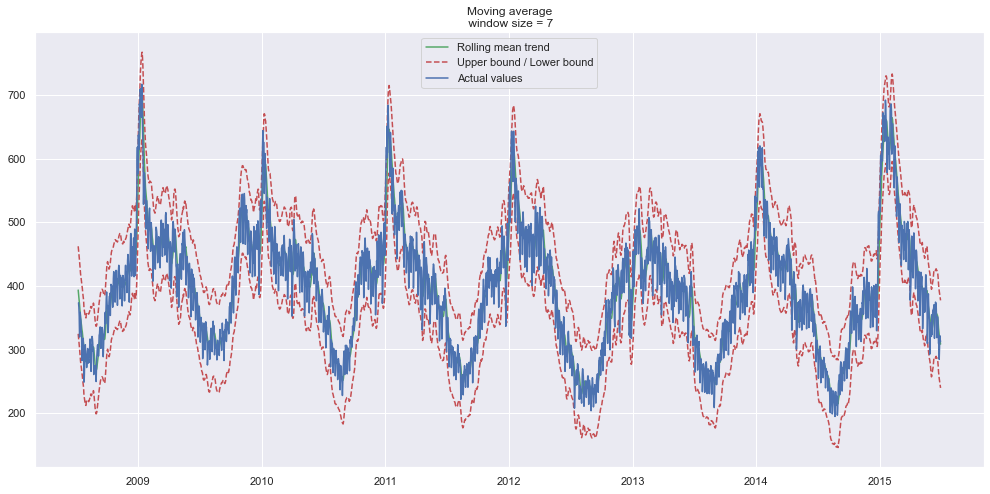

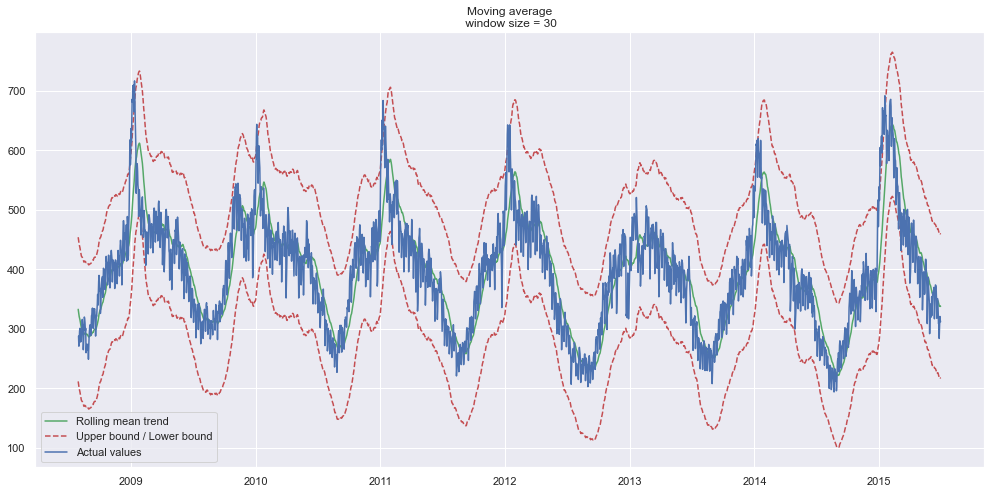

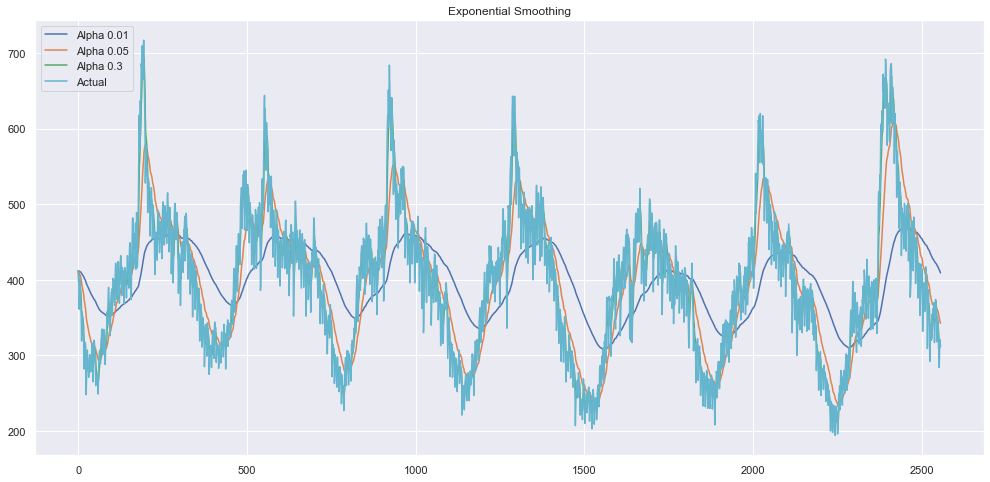

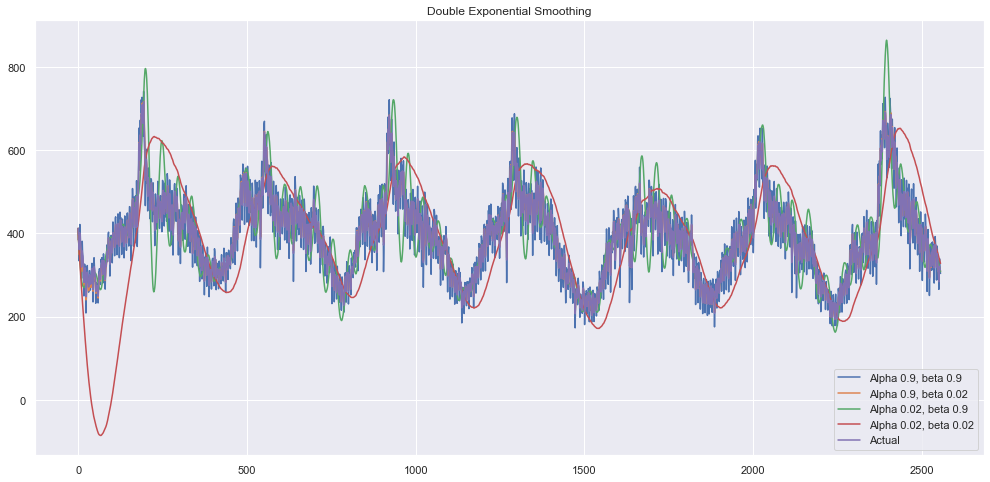

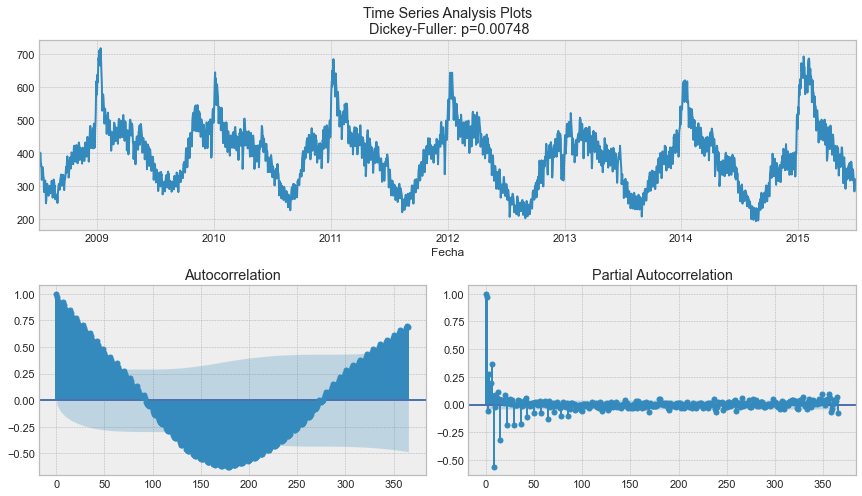

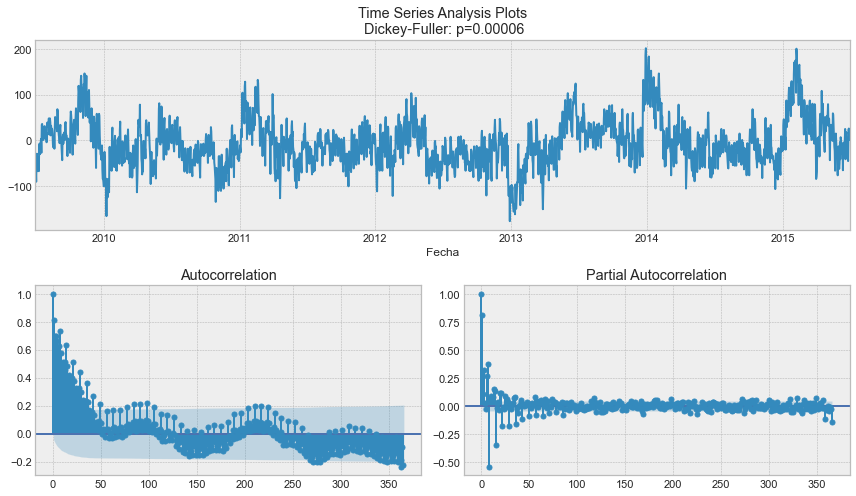

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

target = 'Ocupacion'
fecha_ini = "2008-07-01"
fecha_fin = "2015-07-01"

time_series_df = join_sources_df.loc[(join_sources_df.index >= fecha_ini) & (join_sources_df.index < fecha_fin)]
time_series_df.fillna(method = 'bfill', inplace = True)

# ------------------- Moving average -------------------
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 7 days (by week)
plot_moving_average(time_series_df[target], 7, plot_intervals= True)

#Smooth by the previous month (30 days)
plot_moving_average(time_series_df[target], 30, plot_intervals= True)

# ------------------- Exponential smoothing -------------------
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(time_series_df[target], [0.01, 0.05, 0.3])

# ------------------- Double exponential smoothing -------------------

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(time_series_df[target], alphas=[0.9, 0.02], betas=[0.9, 0.02])

# ------------------- Dickey-Fuller test -------------------
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

lags = 365
tsplot(time_series_df[target], lags= lags)

# Take the first difference to remove to make the process stationary
lag = 365
time_series_diff = time_series_df[target] - time_series_df[target].shift(lag)

tsplot(time_series_diff[lag:], lags= lags)

### EDA

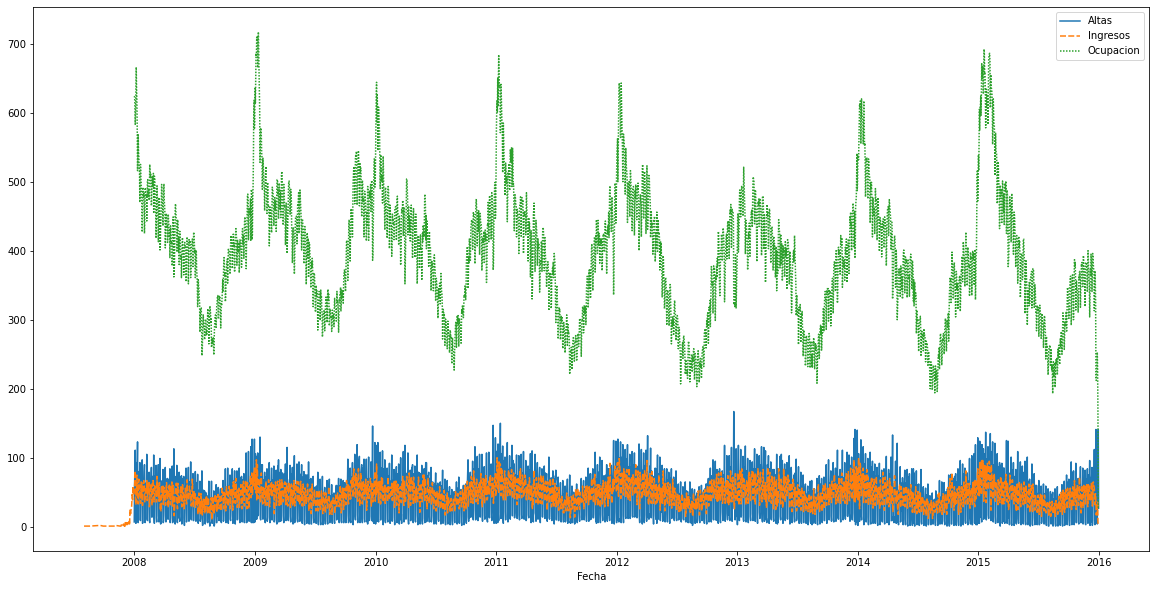

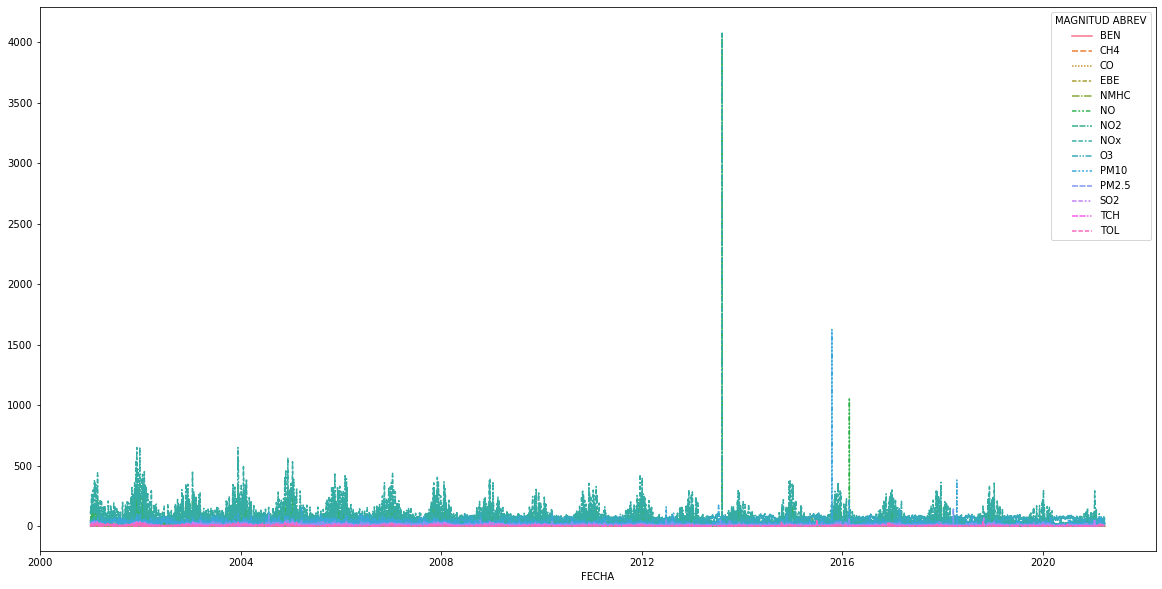

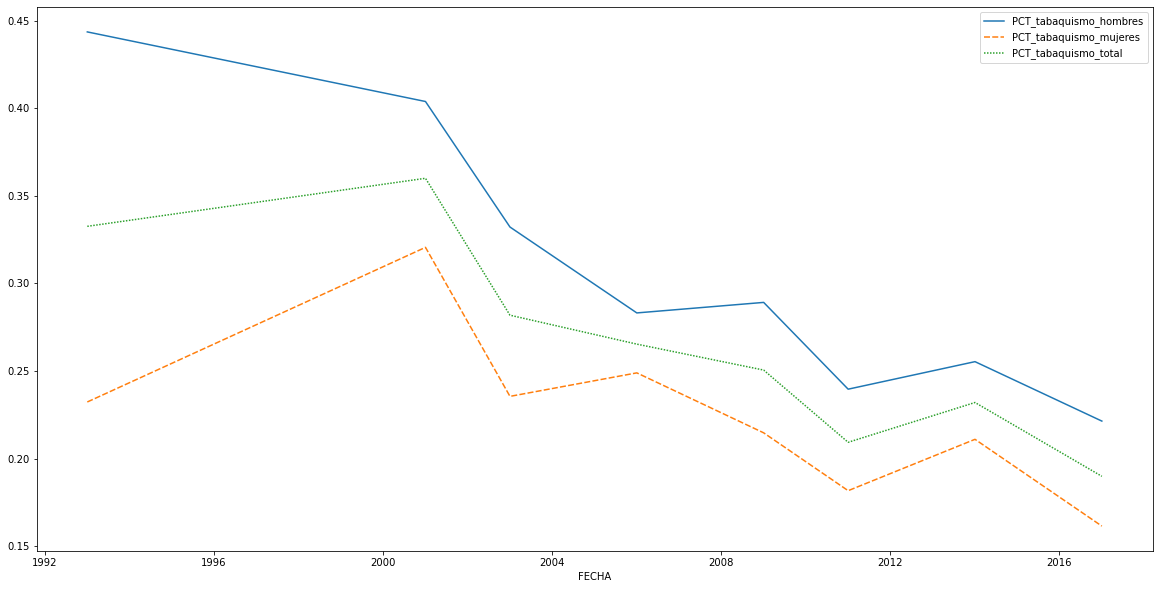

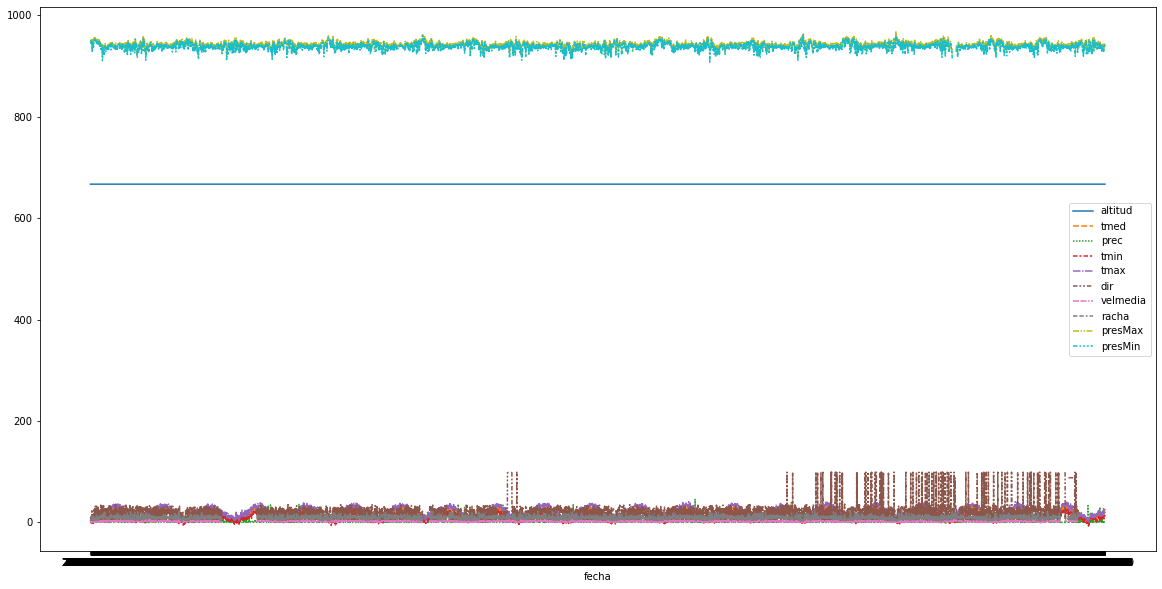

In [6]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plot_cols = ['Altas','Ingresos','Ocupacion']
sns.lineplot(data=hospitalizaciones_df[plot_cols], ax = ax);

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=calidad_aire_df, ax = ax);

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
filtro = tabaquismo_df['CCAA'] == "Comunidad de Madrid"
sns.lineplot(data=tabaquismo_df.loc[filtro], ax = ax);

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=climatologia_df, ax = ax);